In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! tar -xvf viton_resize.tar.gz

In [4]:
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

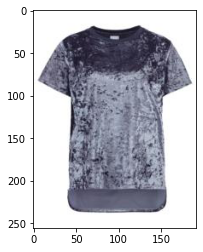

In [5]:
root = "viton_resize/train/"
cloth = os.path.join(root, 'cloth')
fp = os.path.join(cloth, random.sample(os.listdir(cloth), 1)[0])
img = plt.imread(fp)
plt.imshow(img)

In [6]:
import os
import cv2
import random
import json
from collections import defaultdict

class GarmentParser:
    def __init__(self, root):
        self.root = root
        self.image_dir = os.path.join(root, 'image')
        self.image_parse_dir = os.path.join(root, 'image-parse')
        self.cloth_dir = os.path.join(root, 'cloth')
        self.cloth_mask_dir = os.path.join(root, 'cloth-mask')
        self.pose_dir = os.path.join(root, 'pose')
        self.id_map = defaultdict(dict)
        self.build()

    def build(self):
        for img_fp in os.listdir(self.image_dir):
            id = img_fp.split('_')[0]
            self.id_map[id]['image'] = os.path.join(self.image_dir, img_fp)
        for img_mask_fp in os.listdir(self.image_parse_dir):
            id = img_mask_fp.split('_')[0]
            self.id_map[id]['image_mask'] = os.path.join(self.image_parse_dir, 
                                                         img_mask_fp)
        for cloth_fp in os.listdir(self.cloth_dir):
            id = cloth_fp.split('_')[0]
            self.id_map[id]['cloth'] = os.path.join(self.cloth_dir, cloth_fp)
        for cloth_mask_fp in os.listdir(self.cloth_mask_dir):
            id = cloth_mask_fp.split('_')[0]
            self.id_map[id]['cloth_mask'] = os.path.join(self.cloth_mask_dir, 
                                                    cloth_mask_fp)
        for pose_fp in os.listdir(self.pose_dir):
            id = pose_fp.split('_')[0]
            with open(os.path.join(self.pose_dir, pose_fp)) as f:
                info = json.load(f)
            self.id_map[id]['people'] = info['people']

    def load(self, id):
        return self.id_map[id]

    def load_random(self):
        id = random.sample(self.id_map.keys(), 1)[0]
        return id, self.load(id)

    def __len__(self):
        return len(self.id_map)

In [7]:
gparser = GarmentParser("./viton_resize/train")

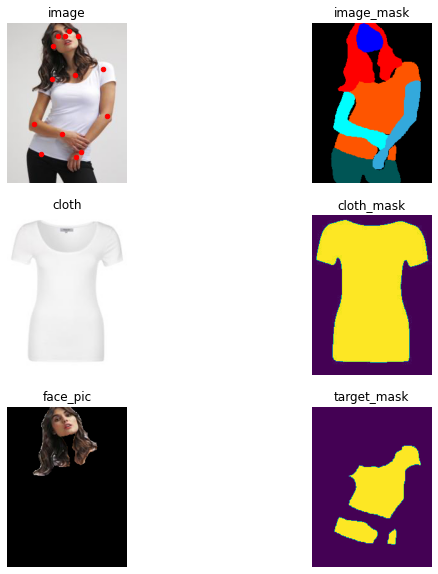

In [8]:
id, sample = gparser.load_random()
plt.figure(figsize=(10, 10))
for i, k in enumerate([k for k in sample if k != 'people']):
    plt.subplot(3, 2, i+1)
    plt.title(k)
    plt.imshow(plt.imread(sample[k]))
    if k == 'image':
        kps = np.array(sample['people'][0]['pose_keypoints']).reshape(-1, 3)
        kps = kps[np.where(kps[:, -1] > 0)]
        plt.scatter(kps[:, 0], kps[:, 1], s=20, c='red')
    plt.axis('off')

plt.subplot(3, 2, 5)
image = plt.imread(sample['image'])
image_mask = plt.imread(sample['image_mask']).sum(-1)
face_mask = np.where(np.abs(image_mask-1.) < 0.1, 1, 0)
face_pic = image * face_mask[..., None]
plt.imshow(face_pic)
plt.title('face_pic')
plt.axis('off')

plt.subplot(3, 2, 6)
image_mask = plt.imread(sample['image_mask']).sum(-1)
body_mask = np.where(np.abs(image_mask-1.3294117) < 0.1, 1, 0)
body_mask = (image_mask * body_mask).astype(bool)
plt.imshow(body_mask)
plt.title('target_mask')
plt.axis('off');

In [9]:
! rm -rf DL-models-experiments/
! git clone https://github.com/einstalek/DL-models-experiments.git
import sys
sys.path.append("./DL-models-experiments/")

Cloning into 'DL-models-experiments'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 379 (delta 8), reused 19 (delta 6), pack-reused 354
Receiving objects: 100% (379/379), 16.18 MiB | 42.36 MiB/s, done.
Resolving deltas: 100% (224/224), done.


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from models.unet import Unet
import albumentations as A

In [11]:
class DescriptorDataset(Dataset):
    def __init__(self, gparser, split='train', 
                 image_size=(256, 192), 
                 kp_thresh=0.1, kp_rad=10):
        super(DescriptorDataset, self).__init__()
        self.gparser = gparser
        self.split = split
        self.image_size = image_size
        self.kp_thresh = kp_thresh
        self.kp_rad = kp_rad
        self.hid_size = (16, 32)

    def __getitem__(self, idx):
        if self.split == 'train':
            id, sample = self.gparser.load_random()
        else:
            pass
        image = cv2.imread(sample['image'])[..., ::-1] / 255
        image_mask = cv2.imread(sample['image_mask'])[..., ::-1] / 255.
        hand_mask = np.where(image_mask[..., 1] > 0.5, 1, 0)
        image_mask = image_mask.sum(2)
        face_mask = np.where(np.abs(image_mask-1.) < 0.1, 1, 0)
        hand_mask = hand_mask * self.binary_mask(sample, ids=[4, 7], rad=30).sum(2)
        lower_body_mask = np.where(np.abs(image_mask-0.66) < 0.1, 1, 0)
        body_mask = np.where(np.abs(image_mask-1) > 0.1, 1, 0)
        face_pic = image * (hand_mask[..., None] + \
                            face_mask[..., None] + \
                            lower_body_mask[..., None]).astype(np.float32)
        body_mask = (image_mask * body_mask).astype(bool).astype(np.float32)
        up_cloth_mask = np.where(np.abs(image_mask-1.3294117) < 0.1, 1, 0)
        body_mask_down = cv2.resize(body_mask, self.hid_size)
        body_mask_down = cv2.resize(body_mask_down, self.image_size[::-1])
        body_mask_down = body_mask_down[..., None]
        kps_mask = self.binary_mask(sample)
        cloth = cv2.imread(sample['cloth']) / 255.
        desc = np.concatenate([kps_mask, body_mask_down, 
                               face_pic, cloth], axis=2)
        target = np.concatenate([up_cloth_mask[..., None], image], axis=2)
        return self.preprocess(desc), self.preprocess(target)

    def binary_mask(self, sample, ids=None, rad=None):
        if rad is None:
            rad = self.kp_rad
        assert len(sample['people']) == 1
        kps = np.array(sample['people'][0]['pose_keypoints']).reshape(-1, 3)
        if ids is not None:
            kps = kps[ids]
        N, _ = kps.shape
        H, W = self.image_size
        mask = np.zeros((*self.image_size, N))
        for i in range(N):
            kp_x, kp_y, kp_proba = kps[i]
            kp_x, kp_y = int(kp_x), int(kp_y)
            if kp_proba < self.kp_thresh:
                continue
            lim_low_x, lim_low_y = max(0, kp_x - rad), max(0, kp_y - rad)
            lim_high_x, lim_high_y = min(W-1, kp_x+rad), min(H-1, kp_y+rad)
            for xx in range(lim_low_x, lim_high_x):
                for yy in range(lim_low_y, lim_high_y):
                    if (xx-kp_x)**2 + (yy-kp_y)**2 < rad**2:
                        mask[yy, xx, i] = 1.
        return mask

    def preprocess(self, inp):
        if len(inp.shape) == 2:
            inp = inp[..., None]
        inp = inp.transpose(2, 0, 1)
        inp = torch.from_numpy(inp)
        inp = (inp - 0.5) / 0.5
        return inp.float()
            
    def __len__(self):
        return len(self.gparser)

In [12]:
data = DescriptorDataset(gparser)
desc, gt = data[0]
desc.shape, gt.shape

(torch.Size([25, 256, 192]), torch.Size([4, 256, 192]))

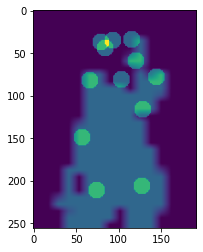

In [15]:
plt.imshow(desc[:19].sum(0).detach())

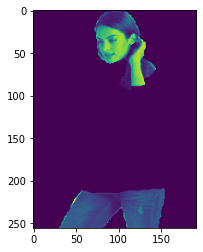

In [16]:
plt.imshow(desc[19:22].sum(0).detach())

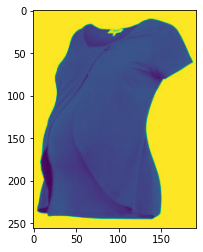

In [17]:
plt.imshow(desc[22:].sum(0).detach())

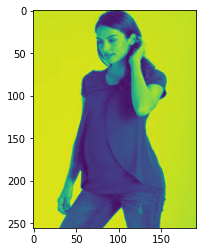

In [18]:
plt.imshow(gt[1:].sum(0).detach())

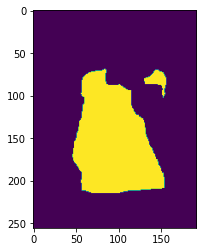

In [19]:
plt.imshow(gt[0].detach())

In [14]:
from collections import defaultdict
import tqdm

class Logger:
    def __init__(self):
        self.loss = defaultdict(list)
    
    def update(self, **loss):
        for (k, v) in loss.items():
            self.loss[k].append(v)
        
logger = Logger()

In [15]:
data = DescriptorDataset(gparser)
loader = DataLoader(data, shuffle=True, batch_size=24, num_workers=8)
logger = Logger()

unet = Unet(25, 4, activation='tanh').cuda()
crit = torch.nn.SmoothL1Loss()
opt = torch.optim.Adam(unet.parameters(), 1e-4, (0., 0.99))

In [16]:
ckpt = torch.load("/content/drive/MyDrive/kaggle/DL-models-experiments/ckpt.pth", 
                  map_location=torch.device('cuda'))
unet.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [ ]:
from torchvision.models import vgg
vgg_model = vgg.vgg19(pretrained=True).eval()

from collections import namedtuple
LossOutput = namedtuple("LossOutput", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])

class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

loss_model = LossNetwork(vgg_model).cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [17]:
from IPython import display

In [18]:
def train_step(desc, gt, model, opt, crit, device='cuda'):
    desc = desc.to(device)
    out = model(desc)
    l1_loss = crit(gt, out)
    perc_loss = perceptual_loss(gt[:, 1:], out[:, 1:], loss_model, crit)
    loss = l1_loss + perc_loss
    loss.backward()
    opt.step()
    return l1_loss, perc_loss, loss

def train_single_epoch(model, opt, dataloader, logger, 
                       crit, epoch, postfix_dict={}, device="cuda"):
    model.train()
    total_step = len(dataloader)
    total_loss = {"loss": 0., "total": 0.}
    tbar = tqdm.tqdm(enumerate(dataloader), total=total_step, position=0)
    for i, (desc, gt) in tbar:
        desc = desc.to(device)
        gt = gt.to(device)
        l1_loss, perc_loss, loss = train_step(desc, gt, model, opt, crit, device=device)
        total_loss["total"] += loss.item()
        postfix_dict["l1_loss"] = l1_loss.item()
        postfix_dict["perc_loss"] = perc_loss.item()
        f_epoch = epoch + i / total_step
        desc = '{:5s}'.format('train')
        desc += ', {:06d}/{:06d}, {:.2f} epoch'.format(i, total_step, f_epoch)
        tbar.set_description(desc)
        tbar.set_postfix(**postfix_dict)
    total_loss["total"] /= total_step
    logger.update(**total_loss)

def display_result(model, data, device='cuda'):
    _ = model.eval()
    desc, gt = data[0]
    out = model(desc[None].to(device))
    pic = out.detach().cpu().numpy()[0, 1:].transpose(1, 2, 0)
    pic = 0.5 + 0.5 * pic
    display.clear_output(wait=True)
    plt.figure(figsize=(10, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(pic)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    pic = gt.detach().cpu().numpy()[1:].transpose(1, 2, 0)
    pic = 0.5 + 0.5 * pic
    plt.imshow(pic)
    plt.subplot(1, 3, 3)
    plt.imshow(out.detach().cpu().numpy()[0, 0])
    plt.axis('off')
    plt.show()

def train(model, opt, dataloader, crit, logger, epochs=10):
    for epoch in range(epochs):
        train_single_epoch(model, opt, dataloader, logger, crit, epoch)
        display_result(model, data)
        
def perceptual_loss(gt, out, loss_model, crit):
    mean = torch.tensor([0.485, 0.456, 0.406])[None, :, None, None].cuda()
    std = torch.tensor([0.229, 0.224, 0.225])[None, :, None, None].cuda()
    gt = (gt + 1.) / 2.
    gt = (gt - mean) / std
    out = (out + 1.) / 2.
    out = (out - mean) / std
    feats1 = loss_model(gt)
    feats2 = loss_model(out)
    loss = 0.
    for (x, y) in zip(feats1, feats2):
        loss += crit(x, y)
    return loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


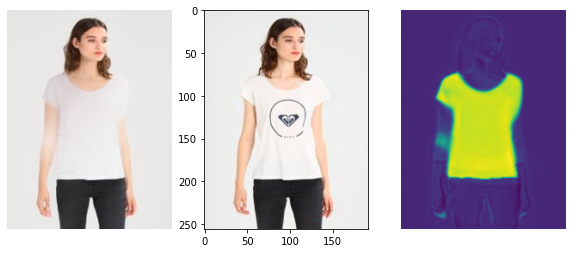

In [ ]:
train(unet, opt, loader, crit, logger, 2)

In [ ]:
ckpt = {'state_dict': unet.state_dict(), 'epoch': 12}
torch.save(ckpt, "ckpt.pth")

In [ ]:
! cp ./ckpt.pth /content/drive/MyDrive/kaggle/DL-models-experiments/

In [32]:
gparser = GarmentParser("./viton_resize/test")
data = DescriptorDataset(gparser)
_ = unet.eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


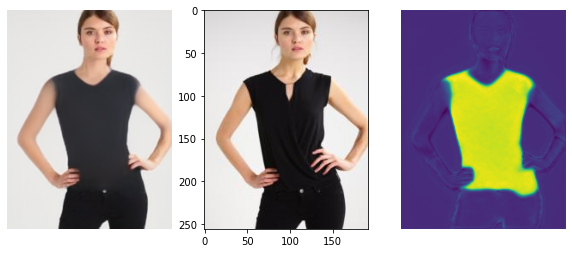

In [35]:
display_result(unet, data)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


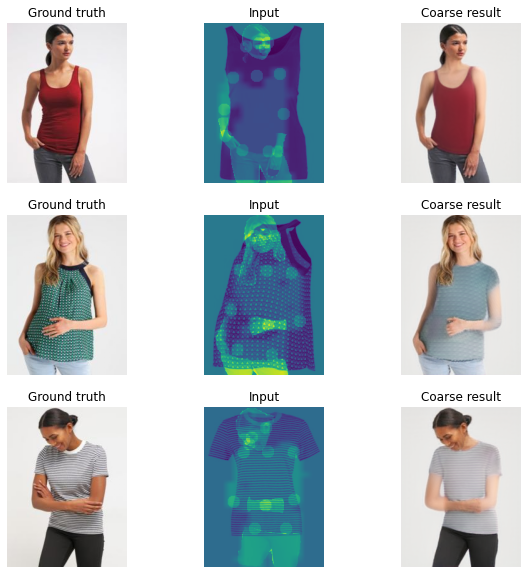

In [81]:
plt.figure(figsize=(10, 10))
for i in range(3):
    desc, gt = data[0]
    out = unet(desc[None].cuda())
    pic = out.detach().cpu().numpy()[0, 1:].transpose(1, 2, 0)
    pic = 0.5 + 0.5 * pic
    plt.subplot(3, 3, 2*i + i+3)
    plt.imshow(pic)
    plt.title('Coarse result')
    plt.axis('off')
    plt.subplot(3, 3, 2*i + i+2)
    pic = desc.sum(0).detach().cpu().numpy()
    plt.imshow(pic)
    plt.title('Input')
    plt.axis('off')
    plt.subplot(3, 3, 2*i + i+1)
    pic = gt[1:].detach().cpu().numpy().transpose(1, 2, 0)
    pic = 0.5 + 0.5 * pic
    plt.imshow(pic)
    plt.title('Ground truth')
    plt.axis('off')